# 비트코인 분석 툴 1: Crypto LM 기반 유사 암호화폐 뉴스 검색기 (Pointwise) 

In [105]:
import numpy as np 
import pandas as pd 
import os 
import random 
from tqdm.auto import tqdm 
import time 
import datetime 
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, IterableDataset 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import logging 
logging.disable(logging.WARNING)  
from transformers import XLMRobertaForSequenceClassification, AutoConfig, AutoModel 
from tokenization_roberta_spm import FairSeqRobertaSentencePieceTokenizer 
import faiss
import json 
import math 
import ccxt 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_finance import candlestick_ohlc # pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
import pandas_ta as ta
import mplfinance as mpf
from datetime import datetime, timedelta

# 크립토 언어모델 정의 (텍스트 임베딩 추출용) 

제가 참여한 논문에서 소개한 CryptoRoBERTa를 활용합니다. 

저희 논문링크입니다: https://ieeexplore.ieee.org/document/10014986 

언어모델에 대해서 궁금하시면 저희 논문을 보시는걸 추천드립니다. 

In [2]:
tokenizer = FairSeqRobertaSentencePieceTokenizer.from_pretrained("fairseq-roberta-all-model") 
model = AutoModel.from_pretrained("axiomlabs/KR-cryptoroberta-base") 
config = AutoConfig.from_pretrained("axiomlabs/KR-cryptoroberta-base") 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device) 
model.eval() 

[PASS] spm_id: madeupword0000 | fairseq_id: 51998
[PASS] spm_id: madeupword0001 | fairseq_id: 51999


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(52001, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0): XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      

# 감성분류용 언어모델 정의 

해당 기사가 비트코인 가격에 대해서 호재성인지, 악재성인지 중립적인지 분류해주는 언어모델입니다. 

In [3]:
sentiment_model = XLMRobertaForSequenceClassification.from_pretrained("axiomlabs/KR-cryptoroberta-base") 
sentiment_model.to(device) 
sentiment_model.eval() 

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(52001, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [4]:
def get_sentiment_score(text): 
    encoded_inputs = tokenizer(text, max_length=512, padding="max_length", truncation=True, return_tensors="pt").to(device) 
    with torch.no_grad(): 
        sentiment = sentiment_model(**encoded_inputs)[0] 
        sentiment = nn.Softmax(dim=1)(sentiment)[0] 
    return sentiment 

# 계산된 과거 뉴스들 (Candidate News) 임베딩 로드하기 

과거에 나온 뉴스들의 임베딩을 CryptoRoBERTa로 미리 계산해뒀습니다. 저장된 후보 뉴스 임베딩을 로드하고 빠른 임베딩 유사도 검색을 위해서 FAISS index를 빌드해줍니다. 

In [5]:
# coinness news ranging from 2018-01-19 2pm to 2023-04-21 11am 
candidate_embeddings = torch.load("candidate_embeddings_20230421.pt")

candidate_embeddings.shape

(122261, 768)

In [6]:
# building our faiss index 
# not using GPU for searching for this demo 
use_cosine_sim = True # 코사인 유사도 사용 
if use_cosine_sim: 
    index = faiss.IndexIDMap2(faiss.IndexFlatIP(config.hidden_size)) 
    faiss.normalize_L2(candidate_embeddings.astype(np.float32)) 
else: # defaults to L2 
    index = faiss.IndexIDMap2(faiss.IndexFlatL2(config.hidden_size)) 

index.add_with_ids(candidate_embeddings.astype(np.float32), np.array(range(0, len(candidate_embeddings)), dtype=int)) 
index.nprobe = 64 

# Candidate News 텍스트 로드하기 

긁어온 코인니스 뉴스의 텍스트를 불러옵니다. 유사한 candidate news들의 인덱스를 기반으로 텍스트를 보여줘야하기 때문입니다. 

In [7]:
news_df = pd.read_csv("coinness_2023_04_21.csv") 

news_df

,titles,contents,year,month,day,hour
0,"케이사인, IoT 보안·블록체인 기술 개발 강화",정보보안 전문기업 케이사인이 4차 산업 시대의 핵심인 사물인터넷(IoT) 보안과 블...,2018,1,19,14
1,"美 테네시 주, 블록체인 법안 도입 검토…""긍정적""",테네시 주 의회가 법안 심리에서 법률 전자 기록에 블록체인 서명 사용을 승인하는 법...,2018,1,26,15
2,"노원구, 블록체인 기반 지역화폐 '노원(NW)' 가맹점 모집",노원구가 국내 최초 블록체인 기반 지역화폐 '노원(NW)'의 시행을 앞두고 가맹점을...,2018,1,26,15
3,"日 정부, 일본 내 모든 암호화폐 거래소 긴급 실태조사…코인체크 사건 후폭풍",일본 정부가 최근 암호화폐 거래소 코인체크 해킹 사건을 계기로 모든 거래소에 대해 ...,2018,1,30,16
4,"中 첫 암호화폐 거래소, 홍콩 펀드에 인수",중국의 첫 비트코인 거래소가 홍콩 블록체인 투자 펀드에 인수됐다. 30일(현지시간)...,2018,1,30,17
...,...,...,...,...,...,...
122256,"앱토스, 검증자 위임 스테이킹 기능 출시",레이어1 블록체인 프로젝트 앱토스(APT)가 공식 채널을 통해 네트워크 검증자에 스...,2023,4,21,10
122257,"리서치 ""BNB체인 1분기 시총 24.9% 증가, 수수료 수익은 11.7% 감소""",암호화폐 데이터 분석 업체 메사리(Messari)가 최근 발표한 '2023년 1분기...,2023,4,21,10
122258,스타벅스 '퍼스트 스토어 NFT 시리즈' 첫 완판 실패,우블록체인에 따르면 스타벅스가 출시한 NFT 시리즈 가운데 '퍼스트 스토어 컬렉션 ...,2023,4,21,10
122259,"세럼, 트윗 전부 삭제하고 계정 이름도 변경",인터넷 탐정 잭XBT(ZachXBT)에 따르면 세럼(SRM) 트위터 계정이 모든 트...,2023,4,21,11


In [8]:
titles = news_df["titles"].values 
contents = news_df["contents"].values 

years = news_df["year"].values 
months = news_df["month"].values 
days = news_df["day"].values 
hours = news_df["hour"].values 

candidate_texts = [] 
for i in range(len(contents)): 
    s = str(titles[i]) + "\n" + str(contents[i]) 
    candidate_texts.append(s)   
    
candidate_dates = [] 
for i in range(len(years)): 
    cur_date = str(years[i]) + "/" + str(months[i]) + "/" + str(days[i]) + " " + str(hours[i]) + "시" 
    candidate_dates.append(cur_date) 

# 유사 뉴스가 나온 시점의 차트 데이터를 plot해서 보여주는 기능 구현하기 

특정 뉴스가 나온 시점으로부터의 차트 데이터를 보여줍니다. 이 시점부터 유저가 지정한 길이만큼의 차트 데이터가 보여지고, 이때 짧은 추세로 30분봉을 보여주고 차트 데이터에 RSI, MACD와 같은 지표도 추가하여 보여줍니다. 해당 뉴스가 나오고 가격에 어떠한 visible한 움직임이 있었는지 관찰하게 도와주기 위한 툴이라고 생각하시면 됩니다. 


In [88]:
# ticker name = plot title 
def plot_chart(ticker_name, sample_df): 
    colors = ["g" if v >= 0 else "r" for v in sample_df["MACDh_12_26_9"]] 
    macd_plot = mpf.make_addplot(sample_df["MACD_12_26_9"], panel=1, color="fuchsia", title="MACD") 
    macd_hist_plot = mpf.make_addplot(sample_df["MACDh_12_26_9"], type="bar", panel=1, color=colors) 
    macd_signal_plot = mpf.make_addplot(sample_df["MACDs_12_26_9"], panel=1, color="b") 

    rsi6_plot = mpf.make_addplot(sample_df["rsi6"], panel=3, color="orange", title="RSI") 
    rsi12_plot = mpf.make_addplot(sample_df["rsi12"], panel=3, color="aquamarine") 
    rsi24_plot = mpf.make_addplot(sample_df["rsi24"], panel=3, color="yellow") 

    plots = [macd_plot, macd_hist_plot, macd_signal_plot, rsi6_plot, rsi12_plot, rsi24_plot] 
    mpf.plot(sample_df, type="candle", style="yahoo", mav=(5, 10), addplot=plots, title=f"\n{ticker_name}", volume=True, volume_panel=2, ylabel="USDT", ylabel_lower="")

In [75]:
# BTCUSDT from binance 
def convert_json_to_pd(json_file: str):
    with open(json_file) as f: 
        d = json.load(f) 
    chart_df = pd.DataFrame(d) 
    chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})
    binance = ccxt.binance() 
    dates = chart_df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5]
        timestamp.append(date_string) 
    chart_df["datetime"] = timestamp 
    chart_df.drop(columns={"timestamp"}, inplace=True) 
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True) 
    return chart_df 

In [91]:
def add_technical_indicators(df): 
    df = pd.concat([df, df.ta.macd(lookahead=False)], axis=1) 
    df["rsi6"] = df.ta.rsi(length=6) 
    df["rsi12"] = df.ta.rsi(length=12) 
    df["rsi24"] = df.ta.rsi(length=24) 
    df.dropna(inplace=True) 
    return df 

In [126]:
def plot_relevant_chart_segment(df, datestr): 
    df30_idx = -1 
    cur_date = df["datetime"].values
    news_datestr = datetime.strptime(datestr, "%Y/%m/%d %H") 
    for i in range(len(cur_date)):
        current_date = datetime.strptime(cur_date[i], "%Y-%m-%d %H:%M:%S") 
        next_date = datetime.strptime(cur_date[i+1], "%Y-%m-%d %H:%M:%S") 
        if news_datestr >= current_date and news_datestr < next_date:
            df30_idx = i 
            break 
    return df30_idx 

In [132]:
# read 30m BTCUSDT chart data
df30 = convert_json_to_pd("BTC_USDT-30m-3.json")
df30 = add_technical_indicators(df30) 

# 쿼리 뉴스가 들어왔을때 유사한 과거 뉴스를 랭킹해서 보여주는 기능 예시

유사 과거 뉴스와, 해당 뉴스가 나왔던 대략적인 시점, 그리고 해당 뉴스가 비트코인 가격에 어떤 영향을 끼칠지 언어모델로 분석한 결과도 같이 보여줍니다. 

추가적으로 해당 과거 뉴스가 나왔던 시점의 차트 움직임도 보여줌으로써 유저의 비트코인 추세 분석에 도움을 줍니다. 

query news
FT "온타리오 연기금, 암호화폐 투자 중단...FTX 사태 손실 여파"
파이낸셜타임즈가 FTX 파산 사태로 9500만 달러 상당의 손실을 입은 온타리오 교사연금(OTPP)이 손실 전액을 상각 처리한 뒤 암호화폐 투자에서 손을 떼기로 했다고 보도했다. OTPP 이사장 조 테일러(Jo Taylor)는 "우리는 FTX 사태로 인한 피해 등에 대해 여전히 내부 조사를 진행하고 있다. 또 연금 가입자들의 피드백을 고려했을 때, 다시 암호화폐 투자에 나서는 것은 현명한 처사가 아니라고 생각한다. 아울러 FTX 사태 이전에 우리는 매우 신중히 실사를 진행한 끝에 투자를 단행했지만 기대했던 결과를 얻지 못했다"고 설명했다.
*** 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 10% | 중립: 90% ***





Rank 1

포브스 "FTX 회계 감사 업체 아르마니노, 암호화폐 준비금 감사 서비스 종료"
포브스에 따르면 FTX 회계 감사 업체 아르마니노(Armanino)가 암호화폐 업체에 대한 준비금 증명 감사 서비스를 종료하기로 결정한 것으로 알려졌다. 업계 관계자는 포브스에 "회사 평판 리스크가 커지면서, 아르마니노가 이 같은 결정을 내렸다. 아직 명확한 회계 기준이 없는 암호화폐 업계 고객을 받아들이는 것을 주저하게 됐다"고 설명했다. 아르마니노는 지난 2014년부터 암호화폐 업체 회계 감사 서비스를 시작했으며, 이후 FTX를 포함 넥소, 크라켄, 게이트 아이오 등의 준비금 증명 감사를 맡아왔다. 그러나 최근 FTX의 파산 후 집단 소송에 직면하는 등 어려움을 겪고 있다.
날짜: 2022/12/16 3시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 13% | 중립: 86% ***


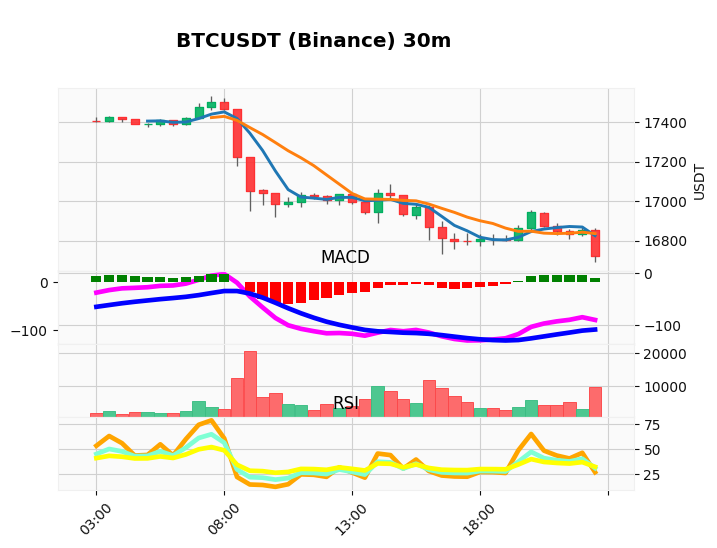



Rank 2

모질라 재단, 커뮤니티 반발에 '암호화폐 후원금 허용' 결정 철회
블룸버그 통신에 따르면, 4대 주요 웹브라우저 중 하나인 파이어폭스(Firefox) 개발사 모질라 코퍼레이션(Mozilla Corporation)을 감독하는 비영리 조직 모질라 재단이 7일 공식 트위터를 통해 "암호화폐 결제 프로세서 비트페이를 통한 암호화폐 후원금 수령을 일시 중단한다"고 밝혔다. 이와 관련 모질라 재단 측은 "탈중앙화 웹 기술은 연구 가치가 있는 중요 분야지만, 우리가 암호화폐로 후원을 받기 시작한 이후 많은 것이 바뀌었다. 재단은 암호화폐 후원금 관련 기존 정책이 친환경 기후 목표와 부합하는지 재검토하고 있으며, 해당 기간 암호화폐 후원금은 받지 않을 예정이다. 정책 검토는 투명하게 진행될 것이고, 우리는 오픈소스 정신에 따라 정기적인 업데이트를 커뮤니티에 공유할 것"이라고 설명했다. 앞서 모질라 재단은 지난 1일(현지 시간) 공식 트위터를 통해 DOGE 등을 포함한 암호화폐 후원금을 받기 시작했다고 밝힌 바 있으며, 이에 '암호화폐는 환경 파괴의 주범'을 주장하는 제이미 자윈스키 모질라 공동 창업자를 필두로 커뮤니티의 반발이 일어난 바 있다.
날짜: 2022/1/7 8시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 13% | 중립: 87% ***


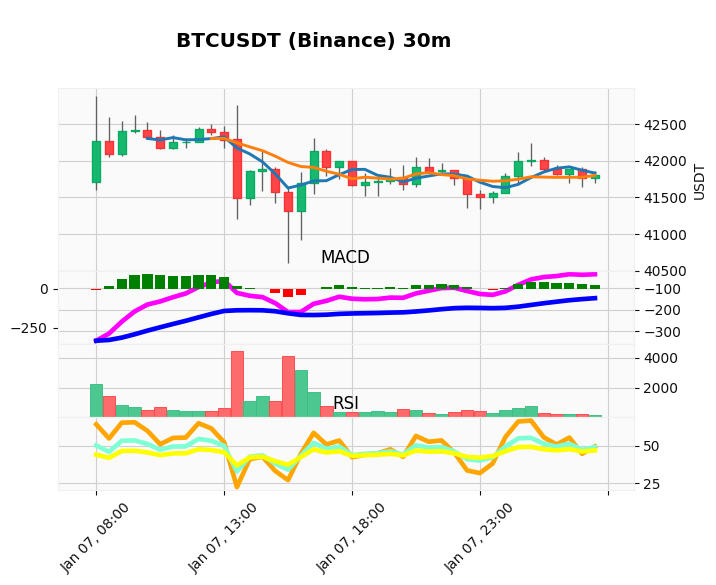



Rank 3

모질라 재단, 커뮤니티 반발에 '암호화폐 후원금 허용' 결정 철회
블룸버그 통신에 따르면, 4대 주요 웹브라우저 중 하나인 파이어폭스(Firefox) 개발사 모질라 코퍼레이션(Mozilla Corporation)을 감독하는 비영리 조직 모질라 재단이 7일 공식 트위터를 통해 "암호화폐 결제 프로세서 비트페이를 통한 암호화폐 후원금 수령을 일시 중단한다"고 밝혔다. 이와 관련 모질라 재단 측은 "탈중앙화 웹 기술은 연구 가치가 있는 중요 분야지만, 우리가 암호화폐로 후원을 받기 시작한 이후 많은 것이 바뀌었다. 재단은 암호화폐 후원금 관련 기존 정책이 친환경 기후 목표와 부합하는지 재검토하고 있으며, 해당 기간 암호화폐 후원금은 받지 않을 예정이다. 정책 검토는 투명하게 진행될 것이고, 우리는 오픈소스 정신에 따라 정기적인 업데이트를 커뮤니티에 공유할 것"이라고 설명했다. 앞서 모질라 재단은 지난 1일(현지 시간) 공식 트위터를 통해 DOGE 등을 포함한 암호화폐 후원금을 받기 시작했다고 밝힌 바 있으며, 이에 '암호화폐는 환경 파괴의 주범'을 주장하는 제이미 자윈스키 모질라 공동 창업자를 필두로 커뮤니티의 반발이 일어난 바 있다.
날짜: 2022/1/6 23시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 13% | 중립: 87% ***


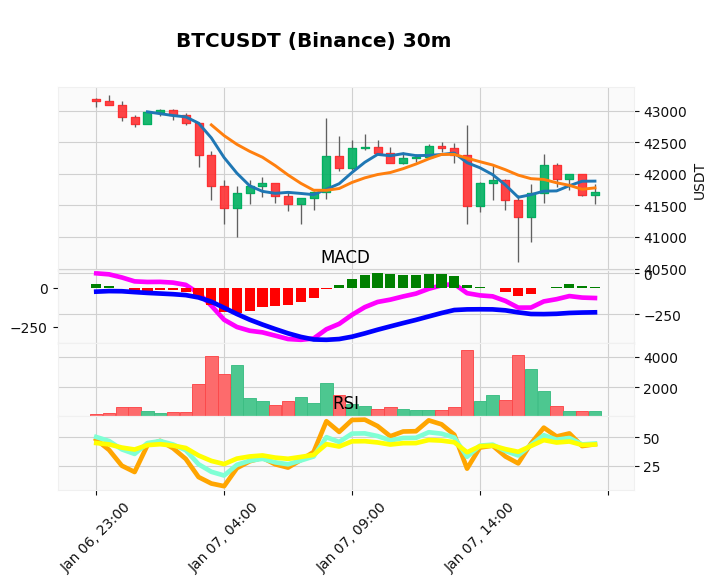



Rank 4

바이낸스 "도매 투자자로 잘못 분류된 호주 사용자 포지션만 강제 종료"
바이낸스가 방금 전 공식 트위터를 통해 "바이낸스 팀은 '도매 투자자'(Wholesale Investors)로 잘못 분류되어 있던 소수의 호주 개인 투자자들을 식별했고, 현지 규정에 따라 해당 사용자들의 파생상품 포지션을 강제 종료했다"고 공지했다. 이어 바이낸스는 "영향을 받은 모든 사용자에게는 이미 연락을 취했으며, 그들이 바이낸스에서 파생상품을 거래하는 동안 발생한 손실에 대해 전액 보상할 것"이라고 덧붙였다. 코인니스는 앞서 암호화폐 커뮤니티를 인용 "바이낸스 호주 플랫폼이 일부 호주 사용자들의 파생상품 포지션을 강제 종료하고 계정을 차단했다"고 전한 바 있다.
날짜: 2023/2/24 8시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 13% | 중립: 86% ***


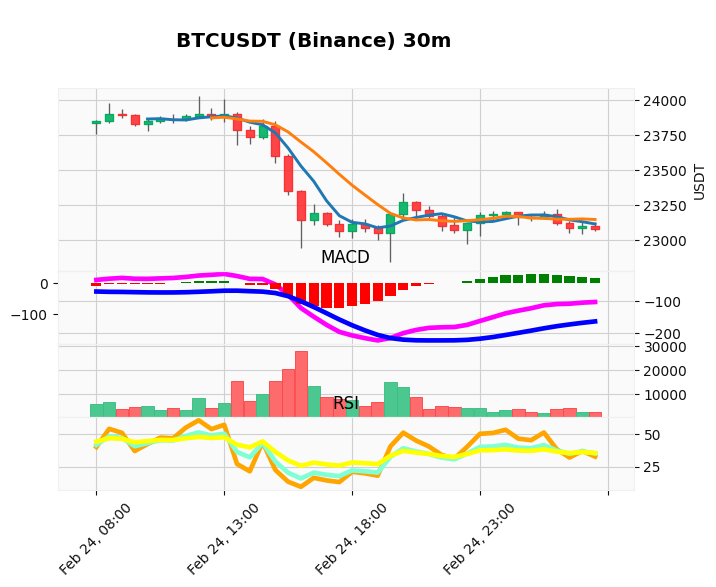



Rank 5

캐나다 연기금, 셀시우스 투자 중단
더블록에 따르면 캐나다 퀘백주 연기금(CDPQ)이 셀시우스에 대한 투자를 중단(writes off)한다고 발표했다. CDPQ는 17일(현지시간) 올해 상반기 평균 수익률이 -7.9%를 기록했으며 셀시우스에 대한 2억 캐나다달러 투자를 중단한다고 밝혔다. CDPQ CEO인 찰스 에몬드(Charles Emond)는 "암호화폐는 과도기에 있는 산업이다. 관련 투자를 너무 빨리 시작했다"고 전했다. 지난해 10월 CDPQ는 웨스트캡과 함께 셀시우스 4억 달러 규모 투자 라운드를 주도한 바 있다. CDPQ는 3,920억 캐나다달러(약 398조 원) 규모의 자산을 관리하는 캐나다 대표 연기금이다.
날짜: 2022/8/18 5시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 22% | 중립: 78% ***


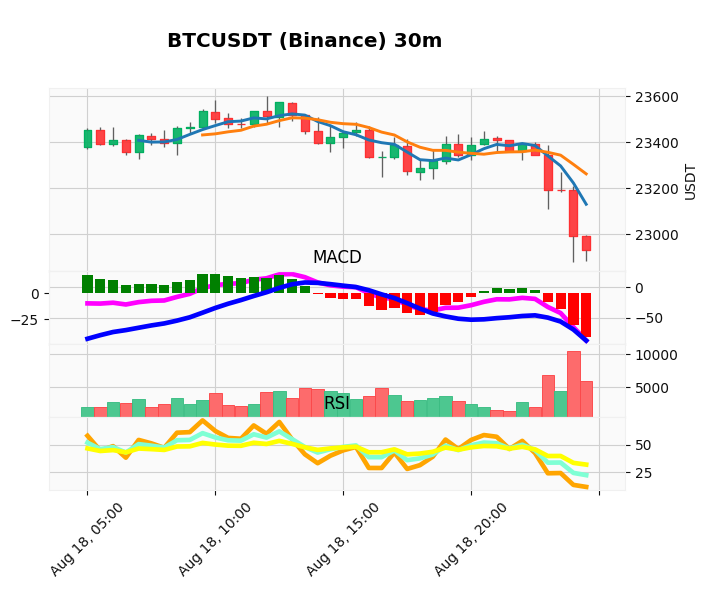



Rank 6

호주 거래소 디지털 서지, 사실상 파산...3만명 고객 계좌 동결
ABC닷넷에 따르면 호주 암호화폐 거래소 디지털 서지(Digital Surge)가 자발적 법정관리에 들어갔다. 사실상 파산이다. 디지털 서지는 지난 달 3만명 고객의 거래 계좌를 동결했다. FTX에 고객 자금이 묶여있는 것으로 알려졌다. 얼마나 묶여있는지는 알려지지 않았다.
날짜: 2022/12/9 14시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 22% | 중립: 78% ***


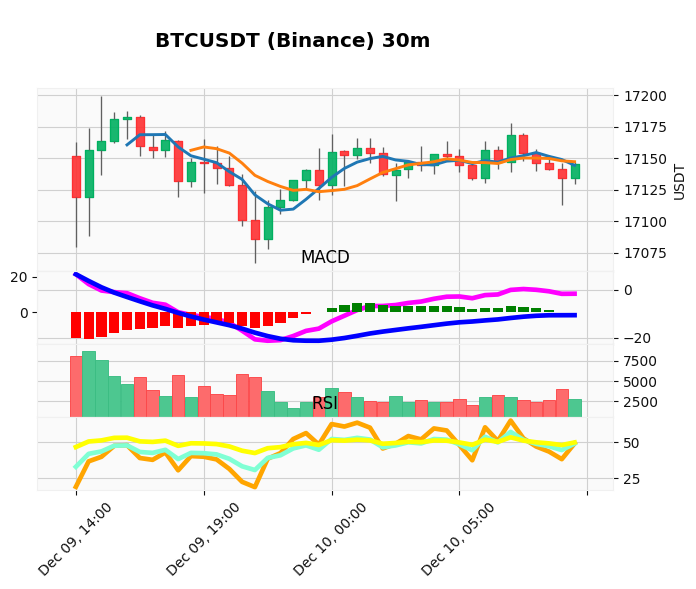



Rank 7

외신 "캐나다 3위 연기금, FTX 유동성 위기로 투자 손실 직면"
현지 미디어 글로브앤메일에 따르면 캐나다 연기금 가운데 세 번째로 규모가 큰 온타리오 티처 연금 플랜(OTTP·Ontario Teachers' Pension Plan)이 FTX의 유동성 위기로 큰 투자 손실을 입을 상황에 직면했다. 미디어는 "OTTP는 지난해 4억 2000만 달러 상당의 FTX 투자 라운드에 참여해 처음으로 지분을 확보하기 시작했다. 투자금은 공개되지 않았으나 전체 69명의 투자자 중 가장 많은 투자금을 냈던 것으로 알려져 있다. 이에 대해 OTTP와 FTX 모두 논평을 거부했다"고 설명했다.
날짜: 2022/11/9 22시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 24% | 중립: 75% ***


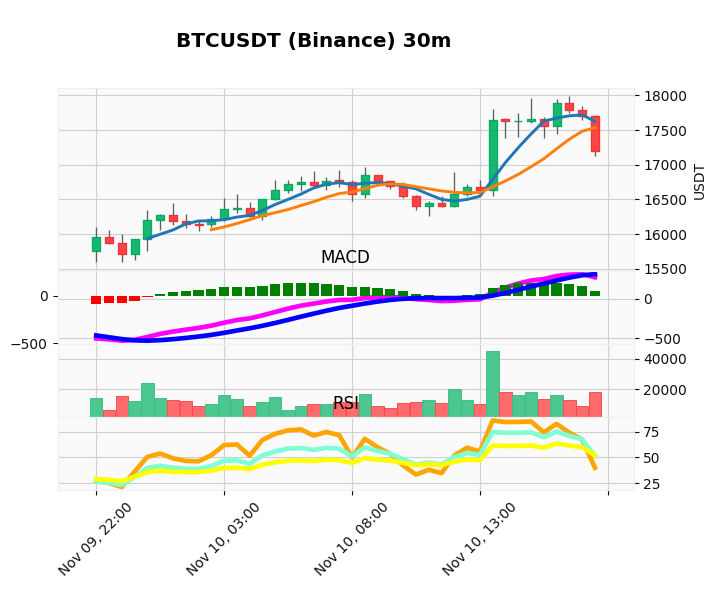



Rank 8

호주 거래소 스위프트엑스, 1/10 예치 이자 서비스 중단
암호화폐 전문 미디어 코인텔레그래프에 따르면, 호주 암호화폐 거래소 스위프트엑스(Swyftx)가 1월 10일(현지시간)부터 암호화폐 예치 이자 서비스 '언 프로그램'(Earn program) 운영을 중단한다. 해당 서비스에 예치된 사용자 자산은 운영 중단과 동시에 사용자의 지갑으로 반환된다. 스위프트엑스는 해당 서비스 중단의 이유로 현지 암호화폐 상품 규제 명확성의 부재를 꼽았다. 이와 관련 스위프트엑스는 "일부 사용자들에게는 실망스러운 소식일 수 있지만, 해당 프로그램을 재개하기 위해 최선을 다할 것"이라고 설명했다.
날짜: 2023/1/9 16시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 0% | 악재: 11% | 중립: 89% ***


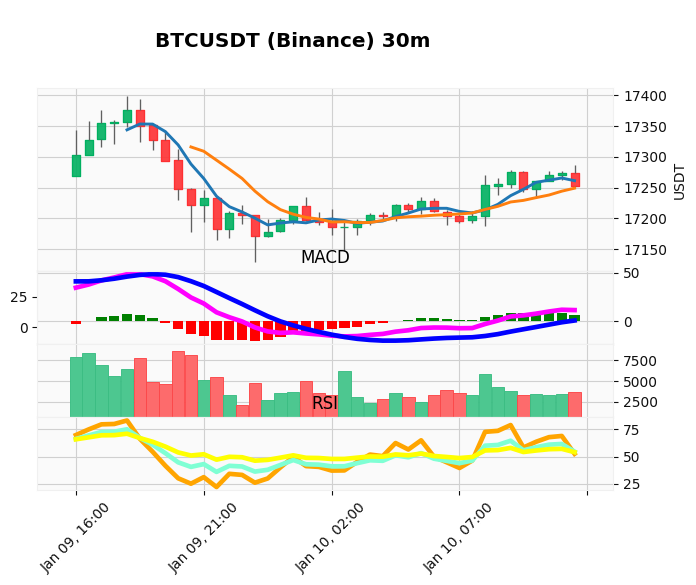



Rank 9

앰버그룹, 올해 성과급 제로...시장 악화 영향
블룸버그에 따르면 파산 위기설에 휩싸인 앰버그룹(Amber Group)이 FTX 붕괴 사태등의 여파로 시장상황이 악화되자 올해 직원 성과급을 지급하지 않기로 했다고 밝혔다. 앰버그룹은 6월부터 정리 해고 및 임금 삭감 등 일련의 비용절감 조치를 취해온 것으로 알려졌다. 앰버그룹 CEO인 미카엘 우(Michael Wu)는 "FTX 붕괴 이전에도 우리는 잠재적으로 다가올 암호화폐 겨울에 대비하고 있었다. 회사는 비용을 절감하고 있으며, 안타깝게도 올해는 성과급 지급이 없을 것이다"라고 전했다. 한편, 앰버그룹은 올해 초 1,100명에 달하던 임직원 수를 400명 미만으로 줄일 것이라고 밝힌 바 있다.
날짜: 2022/12/15 15시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 14% | 중립: 85% ***


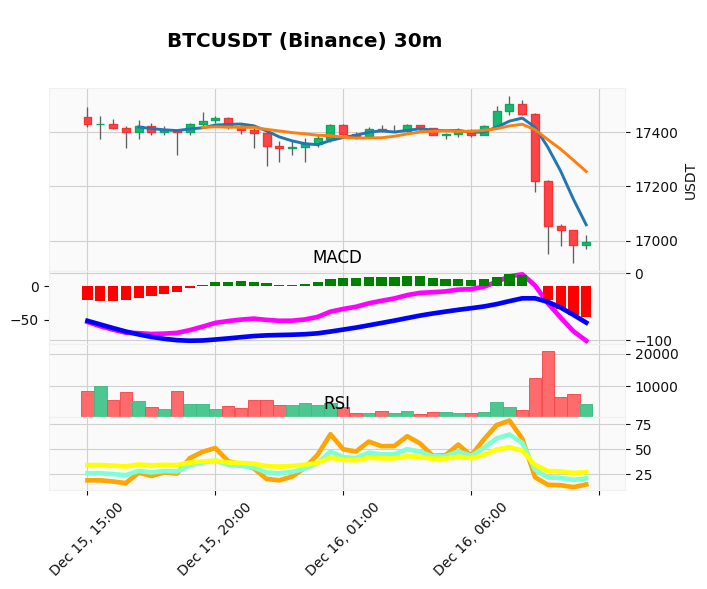



Rank 10

바이낸스, 유로·파운드화 등 선물 마켓 종료
바이낸스가 유로화, 파운드화, 호주 달러화 등 선물 마켓 서비스를 종료한다고 공지했다. 자오창펑 바이낸스 CEO는 앞서 향후 순차적으로 바이낸스 선물 마켓의 레버리지 한도를 최대 20배로 제한해나갈 예정이라고 밝힌 바 있다.
날짜: 2021/7/26 16시
*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: 1% | 악재: 17% | 중립: 82% ***


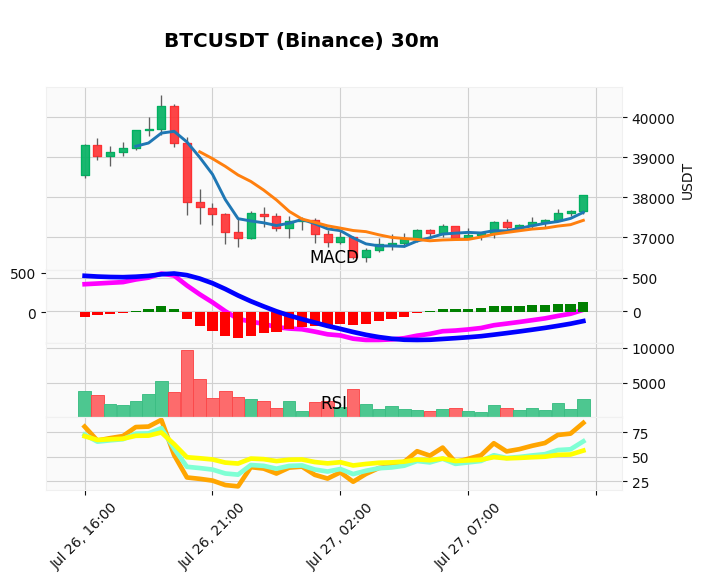

In [134]:
# how much of the chart data do you want to see? this value is specified by the user 
observation_length = 40 

# sample query: 2023-04-21 13:08에 코인니스에 실제로 나온 뉴스 
query_title = """FT \"온타리오 연기금, 암호화폐 투자 중단...FTX 사태 손실 여파\"""" 
query_content = """파이낸셜타임즈가 FTX 파산 사태로 9500만 달러 상당의 손실을 입은 온타리오 교사연금(OTPP)이 손실 전액을 상각 처리한 뒤 암호화폐 투자에서 손을 떼기로 했다고 보도했다. OTPP 이사장 조 테일러(Jo Taylor)는 "우리는 FTX 사태로 인한 피해 등에 대해 여전히 내부 조사를 진행하고 있다. 또 연금 가입자들의 피드백을 고려했을 때, 다시 암호화폐 투자에 나서는 것은 현명한 처사가 아니라고 생각한다. 아울러 FTX 사태 이전에 우리는 매우 신중히 실사를 진행한 끝에 투자를 단행했지만 기대했던 결과를 얻지 못했다"고 설명했다."""

# calculate query embedding 
encoded_query = tokenizer(str(query_title), str(query_content), max_length=512, truncation=True, padding="max_length", return_tensors="pt").to(device) 
query_embedding = model(**encoded_query)[0][:, 0, :].detach().cpu().numpy() 

distances, indices = index.search(query_embedding, 1000) 
topK = 10 # Show only the top 10 similar past news 

# print result 
print("query news") 
query_text = query_title + "\n" + query_content
print(query_text)  
sentiment_scores = get_sentiment_score(query_text) 
sentiment_scores = sentiment_scores.detach().cpu().numpy() 
positive = round(sentiment_scores[0] * 100)  
negative = round(sentiment_scores[1] * 100) 
neutral = round(sentiment_scores[2] * 100) 
print(f"*** 비트코인 가격에 어떤 영향을 미칠까?: 호재: {positive}% | 악재: {negative}% | 중립: {neutral}% ***")

for _ in range(5):
    print() 
    
for i in range(len(indices[0][:topK])): 
    print(f"Rank {i+1}") 
    print() 
    print(candidate_texts[indices[0][i]])  
    print(f"날짜: {candidate_dates[indices[0][i]]}") 
    sentiment_scores = get_sentiment_score(candidate_texts[indices[0][i]]) 
    sentiment_scores = sentiment_scores.detach().cpu().numpy() 
    positive = round(sentiment_scores[0] * 100)  
    negative = round(sentiment_scores[1] * 100) 
    neutral = round(sentiment_scores[2] * 100) 
    print(f"*** 딥러닝 감성점수 분석 - 비트코인 가격에 어떤 영향을 미칠까?: 호재: {positive}% | 악재: {negative}% | 중립: {neutral}% ***")
    
    news_idx = plot_relevant_chart_segment(df30, candidate_dates[indices[0][i]][:-1]) 

    if news_idx != -1: 
        plot_chart("BTCUSDT (Binance) 30m", df30.iloc[news_idx:news_idx+observation_length]) 
    else:
        print("해당 뉴스가 나온 시점의 차트 데이터가 존재하지 않습니다! 다른 차트 데이터 소스를 참고해보세요.") 

    print("=" * 50) 
    print()
    print() 

# ANALYSIS

위 예시를 분석해보면, 쿼리로 암호화폐 투자 중단 관련된 악재성이 높은 뉴스를 예시로 넣었습니다. 저희 감성분류 모델도 악재성이 호재성 점수보다 높다고 판단했지만 중립 점수를 가장 높게 줬습니다. 이것에 대한 이유는 해당 감성분류 모델은 특정 뉴스가 비트코인 가격에 어떻게 영향을 미치는지를 예측하는데, 쿼리 뉴스가 악재성이 짙어도 비트코인 가격에는 직접적으로 영향을 줄 가능성이 낮다고 분석했기 때문입니다. 재밌는점은 쿼리 뉴스와 유사하다고 랭크된 과거 뉴스들을 봤을때 유사 뉴스들이 나온 시점으로부터 대부분 가격이 하락하는 추세를 보이는 경향이 있었습니다. 

물론 이 뉴스 한개 때문에 하락했다고 얘기할수는 없지만 (가격에 영향을 끼치는 요소들은 매우 많습니다) 이러한 언어모델 기반 유사 뉴스 검색 툴이 어느정도 유의미한 지표가 될수도 있습니다. 유사도 계산에 사용된 언어모델은 저희가 만든 크립토 언어모델을 저희 비트코인 감성분류 task에 fine-tuning 시킨걸 zero-shot으로 유사도 계산 태스크에 적용한 것입니다. Zero-shot임에도 불구하고 유사하다고 랭크된 뉴스들이 실제로 쿼리 뉴스와 비슷한 뉘앙스를 가지고 있습니다. 